In [1]:
import cv2
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def _center_loss_func(features, labels, alpha, num_classes,
                      centers, feature_dim):
    assert feature_dim == features.get_shape()[1]
    labels = K.reshape(labels, [-1])
    labels = tf.to_int32(labels)
    centers_batch = tf.gather(centers, labels)
    diff = (1 - alpha) * (centers_batch - features)
    centers = tf.scatter_sub(centers, labels, diff)
    loss = tf.reduce_mean(K.square(features - centers_batch))
    return loss

In [4]:
def center_loss(y_true, y_pred):
  return _center_loss_func(y_pred, y_true, alpha, num_classes, centers, feature_dim)

In [5]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/tao_video/resnet-1-lost-facenet.h5",compile=False, custom_objects={"center_loss": center_loss})

In [7]:
! pip install mtcnn

     |████████████████████████████████| 2.3 MB 12.6 MB/s 


In [8]:
import numpy as np
import cv2 
import os
import time
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import mtcnn
import time
import time
import imutils
from imutils.video import VideoStream
from google.colab.patches import cv2_imshow

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

In [9]:
!pip3 install face_recognition

     |████████████████████████████████| 100.1 MB 23 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=682e730e19b30258a8f7b95d043b2cc5b0921438499444805b05da294d842728
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [10]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/tao_video/cay1.h5",compile=False, custom_objects={"center_loss": center_loss})

In [11]:
img_size = (197, 197)
colors = {0: (0, 0, 255), 1: (153, 51, 200), 2:(204, 0, 102), 3 :(0,255,0) , 4 : (76,0,153) , 5 :(51,153,255), 6:(128,128,128) }
faceNet = cv2.dnn.readNet('/content/deploy.prototxt.txt','/content/res10_300x300_ssd_iter_140000.caffemodel')
label_map = ['tuc gian', 'thu ghet', 'so hai', 'hanh phuc','binh thuong' , 'buon',  'ngac nhien']

In [13]:
def detect_face_and_pre(frame,faceNet,Model):
    (h, w) = frame.shape[:2]
    #conver qua blob
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))
    # cho blod qua model và detect face
    faceNet.setInput(blob)
    detections = faceNet.forward()
    # khởi tạo các list faces, locations tương ứng, predicts tương ứng từ model vì video có thể có nhiều mặt
    faces = []
    locs = []
    preds = []
    for i in range(0, detections.shape[2]):
        # lấy ra độ tin cậy (xác suất,...) tương ứng của mỗi detection
        confidence = detections[0, 0, i, 2]

        # lọc ra các detections đảm bảo độ tin cậy > ngưỡng tin cậy
        if confidence > 0.4:
            # tính toán (x,y) bounding box
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # đảm bảo bounding box nằm trong kích thước frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # trích ra face ROI, chuyển image từ BGR sang RGB, resize về 224x224 và preprocess
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor (face , cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (197, 197))
            face - img_to_array(face)
            #cv2_imshow(face)
            faces.append(face)
            locs.append((startX, startY, endX, endY))
    # nếu detect được mặt thì sẽ dự đoán
    if len(faces) > 0:
        # để nhanh hơn thì predict trên tất cả face thay vì predict trên từng face dùng vòng lặp
        faces = np.array(faces, dtype="float32")
        preds = Model.predict(faces / 255, batch_size=32)
        return (locs, preds)
    else:
        return (-1,-1)

In [15]:

video_capture = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/tao_video/video_demo_1080.mov')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (1920,876)) #1920 × 968
count = 0
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    if (ret == False):
        break
    (locs, preds) = detect_face_and_pre(frame, faceNet, model)
    if locs != -1:
        for (box, pred) in zip(locs, preds):
            # unpack the bounding box and p redictions
            (startX, startY, endX, endY) = box

            label = label_map[np.argmax(pred)]

            color = colors[np.argmax(pred)]
            np.

            # đính thêm thông tin về xác suất(probability) của label
            label = "{}: {:.2f}%".format(label, pred[np.argmax(pred)] * 100.0)
            #print(label)

            # display label và bounding box hình chữ nhật trên output frame
            cv2.putText(frame, label, (startX, startY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    # Display the resulting frameq
    #cv2.imshow('Video', frame)
    out.write(frame)
    count += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
out.release()

In [ ]:
# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

In [98]:
data_test = [
  '/content/drive/MyDrive/Colab Notebooks/tao_video/tuc_gian.jpg',
  '/content/drive/MyDrive/Colab Notebooks/tao_video/hanh_phuc.jpg',
  '/content/drive/MyDrive/Colab Notebooks/tao_video/ngac_nhien.jpg',
  '/content/drive/MyDrive/Colab Notebooks/tao_video/binh_thuong.jpg',
  '/content/drive/MyDrive/Colab Notebooks/tao_video/ngac_nhien_1.jpg',
    '/content/drive/MyDrive/Colab Notebooks/tao_video/ngac_nhien_2.jpg',
      '/content/drive/MyDrive/Colab Notebooks/tao_video/tuc_gian_1.jpg',
  '/content/drive/MyDrive/Colab Notebooks/tao_video/tuc_gian_2.jpg',
]

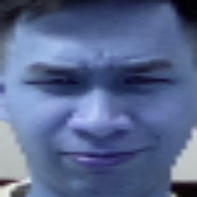

[0.11873087 0.00498571 0.1472149  0.10201832 0.3432581  0.27915427
 0.00463777]
binh thuong: 34.33%


In [105]:
# Test bằng ảnh nè
image = cv2.imread(data_test[-2])
image = cv2.resize(image, (197, 197))
(locs, preds) = detect_face_and_pre(image, faceNet, model)

if locs != -1:
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box

        label = label_map[np.argmax(pred)]
        print(pred)

        color = colors[np.argmax(pred)]

        # đính thêm thông tin về xác suất(probability) của label
        label = "{}: {:.2f}%".format(label, pred[np.argmax(pred)] * 100.0)
        print(label)

        # display label và bounding box hình chữ nhật trên output frame
        cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

In [103]:
image = cv2.imread(data_test[-2])
image = cv2.resize(image, (197, 197))
print(image.shape)
image = image.reshape(1,197,197,3)
preds = model.predict(image /1. / 255, batch_size=32)
label = label_map[np.argmax(preds)]
print(label)
print(preds)

(197, 197, 3)
buon
[[0.10803466 0.00796084 0.1544498  0.14744037 0.21380623 0.2822087
  0.08609942]]
